<a href="https://colab.research.google.com/github/apantovic/used_cars/blob/master/CarPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install catboost
!pip install ipywidgets
!pip install shap
!jupyter nbextension enable --py widgetsnbextension

import shap
from catboost import FeaturesData, Pool, CatBoostRegressor
import pandas as pd
from google.colab import drive
import os
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
drive.mount('/content/gdrive')

     |████████████████████████████████| 63.9MB 61kB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383190 sha256=5d34e5a1ce64e51ae7071e711eaab8809c144322135a4871498f5e62c7414a79
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted

In [0]:
d = 'gdrive/My Drive/Colab Notebooks/CarRecognition/'

In [0]:
df = pd.read_csv(d + 'Data/serbian_car_data.csv')
df.drop([k for k in df.columns if '\n\n' in k], axis=1, inplace=True)

Columns (96,122,123,167) have mixed types. Specify dtype option on import or set low_memory=False.


In [0]:
df.head(3)

,Vozilo:,Marka,Model,Godište,Kilometraža,Karoserija,Gorivo,Kubikaža,Snaga motora,Fiksna cena,Zamena:,Broj oglasa:,Emisiona klasa motora,Pogon,Menjač,Broj vrata,Broj sedišta,Strana volana,Klima,Boja,Materijal enterijera,Boja enterijera,Registrovan do,Poreklo vozila,Oštećenje,Airbag za vozača,Airbag za suvozača,Bočni airbag,Child lock,ABS,ESP,ASR,Kodiran ključ,Blokada motora,Centralno zaključavanje,Metalik boja,Branici u boji auta,Servo volan,Multifunkcionalni volan,Tempomat,...,Panorama krov,Ulazak bez ključa,Asistencija praćenja trake,Webasto,Automatsko parkiranje,Kamera,Prednja noćna kamera,Brisači prednjih farova,Paljenje bez ključa,Hard disk,Elektro podesiva sedišta,Sportsko vešanje,Memorija sedišta,Upravljanje na sva četiri točka,Način prodaje,360 kamera,Elektro zatvaranje prtljažnika,Zavesice na zadnjim prozorima,Vazdušno vešanje,Masažna sedišta,Glasovne komande,Atestiran,Lizing,Gotovinska uplata,Broj rata,Visina rate,Fabrički ugrađeno dečije sedište,Head-up display,Učešće (depozit),Grejanje volana,Volan u kombinaciji drvo/koža,Test vozilo,Tuning,Ventilacija sedišta,Privlačenje vrata pri zatvaranju,Prilagođeno invalidima,Restauriran,Taxi,Oldtimer,Beskamatni kredit
0,Polovno vozilo,Citroen,C4 Picasso,2010. godište,105.000 km,Monovolumen (MiniVan),Dizel,1986 cm3,100/136 (kW/KS),Cena nije fiksna,Zamena: NE,Broj oglasa: 15660418,Euro 4,Prednji,Manuelni 6 brzina,4/5 vrata,5 sedišta,Levi volan,Automatska klima,Srebrna,Štof,Crna,Nije registrovan,Na ime kupca,Nije oštećen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Polovno vozilo,Peugeot,207,2009. godište,225.000 km,Hečbek,Dizel,1560 cm3,66/90 (kW/KS),Cena nije fiksna,Zamena: NE,Broj oglasa: 14297680,Euro 4,Prednji,Manuelni 5 brzina,2/3 vrata,5 sedišta,Levi volan,Manuelna klima,Bela,Štof,Siva,Nije registrovan,Na ime kupca,Nije oštećen,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Polovno vozilo,Volkswagen,Polo,2001. godište,174.801 km,Hečbek,Benzin,1390 cm3,44/60 (kW/KS),Cena nije fiksna,Zamena: NE,Broj oglasa: 15650527,Euro 4,Prednji,Manuelni 5 brzina,4/5 vrata,5 sedišta,Levi volan,Manuelna klima,Siva,Velur,Siva,Nije registrovan,Na ime kupca,Nije oštećen,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df['Model_Make'] = df['Marka'] + '_' + df['Model']
df['Model_Make_Year'] = df['Marka'] + '_' + df['Model'] + '_' + df['Godište'].str.split('. godište',expand=True)[0]
df['Godište'] = pd.Series(df['Godište'].str.split('. godište',expand=True)[0], dtype="float32")
df['Kilometraža'] = pd.Series(df['Kilometraža'].str.split(' km',expand=True)[0].str.replace('.', ''), dtype="float32") 
df['Kubikaža'] = pd.Series(df['Kubikaža'].str.split(' cm3',expand=True)[0], dtype="float32") 
df['Snaga motora_kW'] = pd.Series(df['Snaga motora'].str.split('/',expand=True)[0], dtype="float32") 
df['Snaga motora_KS'] = pd.Series(df['Snaga motora'].str.split('/',expand=True)[1].str.split('(',expand=True)[0], dtype="float32") 
df['Broj vrata'] = pd.Series(df['Broj vrata'].str.split('/',expand=True)[0], dtype="float32") 
df['Broj sedišta'] = pd.Series(df['Broj sedišta'].str.split(' sedišta',expand=True)[0], dtype="float32") 
df['Emisiona klasa motora'] = pd.Series(df['Emisiona klasa motora'].str.split('Euro ',expand=True)[1], dtype="float32") 
df['Price'] = pd.Series(df['Price'].str.split('€',expand=True)[0], dtype="float32")
df = df[(df['Vozilo:']=='Polovno vozilo') & (df['Price']>100)]

df.dropna(subset = ['Price'],inplace=True)
target = df.Price.values
df.drop(['Vozilo:','Snaga motora', 'Fiksna cena','Zamena: ','Webasto', 'Broj oglasa: ', 'Registrovan do', 'Tuning', 'Zavesice na zadnjim prozorima', 'Torba za skije',	'Poreklo vozila', 'Vlasništvo', 'Desc', 'link_to_car', 'Zemlja uvoza', 'Privlačenje vrata pri zatvaranju', 'Prvi vlasnik', 'Kupljen nov u Srbiji','Boja', 'Materijal enterijera','Naslon za ruku', 'Boja enterijera', 'Oštećenje','Metalik boja','Branici u boji auta', 'U ponudi od: ', 'Kredit', 'Način prodaje', 'Lizing', 'Gotovinska uplata', 'Broj rata', 'Visina rate','U ponudi od: ', 'Učešće (depozit)', 'Price', 'Beskamatni kredit', 'Taxi', 'Test vozilo'], inplace=True, axis=1)

df[df.select_dtypes(include='object').columns.tolist()] = df[df.select_dtypes(include='object').columns].fillna('N/A')
df[df.select_dtypes(include=['float64', 'int64']).columns.tolist()] = df[df.select_dtypes(include=['float64', 'int64']).columns].fillna(-1.0)

for c in df.select_dtypes(include=['float64','int64', 'int32']).columns.tolist():
    df[c] = df[c].astype('float32')

In [0]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=100)

# train/valid split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [0]:
X_train['Price'] = y_train
avg = X_train.groupby(['Model_Make_Year']).mean()[['Price']].reset_index()
cnt = X_train.groupby(['Model_Make_Year']).count()[['Marka']].reset_index()
summary = pd.merge(left=cnt, right=avg[['Price']], left_index=True, right_index=True)
summary = summary[summary['Marka']>5]
summary.columns = ['Model_Make_Year', 'Count', 'Avg_Price']

X_train = pd.merge(X_train.drop('Price',axis=1), summary[['Model_Make_Year','Avg_Price']], on=['Model_Make_Year'],how='left')
X_val = pd.merge(X_val, summary[['Model_Make_Year','Avg_Price']], on=['Model_Make_Year'],how='left')
X_test = pd.merge(X_test, summary[['Model_Make_Year','Avg_Price']], on=['Model_Make_Year'],how='left')

X_train.fillna(-1,axis=1,inplace=True)
X_val.fillna(-1,axis=1,inplace=True)
X_test.fillna(-1,axis=1,inplace=True)

In [0]:
a =X_train.head(1)['Model_Make_Year']

In [0]:
a.values[0]

'Škoda_Octavia_2018'

In [0]:
summary[summary['Model_Make_Year']=='AlfaRomeo_147_2001']['Avg_Price'].values

array([], dtype=float32)

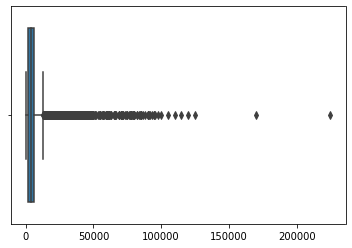

In [0]:
sns.boxplot(x=y_train)

In [0]:
def treat_outliers(pd_series):
    'Outlier treatment using 1.5*IQR range to detect outliers. Input/Output-> pandas Series'
    
    Q1 = np.quantile(pd_series,0.25)
    Q3 = np.quantile(pd_series,0.75)
    IQR = Q3 - Q1
    upper = Q3+3*IQR
    lower = Q1-3*IQR
    pd_series = np.where(pd_series > upper, upper, pd_series)
    pd_series = np.where(pd_series < lower, lower, pd_series)
    
    return pd_series

y_train = treat_outliers(y_train)
y_val = treat_outliers(y_val)
y_test = treat_outliers(y_test)

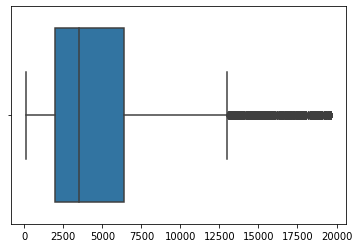

In [0]:
sns.boxplot(x=y_train)

In [0]:
X_train.head(3)

,Marka,Model,Godište,Kilometraža,Karoserija,Gorivo,Kubikaža,Emisiona klasa motora,Pogon,Menjač,Broj vrata,Broj sedišta,Strana volana,Klima,Airbag za vozača,Airbag za suvozača,Bočni airbag,Child lock,ABS,ESP,ASR,Kodiran ključ,Blokada motora,Centralno zaključavanje,Servo volan,Multifunkcionalni volan,Tempomat,Daljinsko zaključavanje,Putni računar,Tonirana stakla,Električni podizači,Električni retrovizori,Grejači retrovizora,Sedišta podesiva po visini,Svetla za maglu,Senzori za svetla,Senzori za kišu,Parking senzori,Aluminijumske felne,Radio CD,...,CD changer,DPF filter,OBD zaštita,Plivajući zamajac,Adaptivni tempomat,Kuka za vuču,Ambijentalno osvetljenje,Mehanička zaštita,Panorama krov,Ulazak bez ključa,Asistencija praćenja trake,Automatsko parkiranje,Kamera,Prednja noćna kamera,Brisači prednjih farova,Paljenje bez ključa,Hard disk,Elektro podesiva sedišta,Sportsko vešanje,Memorija sedišta,Upravljanje na sva četiri točka,360 kamera,Elektro zatvaranje prtljažnika,Vazdušno vešanje,Masažna sedišta,Glasovne komande,Atestiran,Fabrički ugrađeno dečije sedište,Head-up display,Grejanje volana,Volan u kombinaciji drvo/koža,Ventilacija sedišta,Prilagođeno invalidima,Restauriran,Oldtimer,Model_Make,Model_Make_Year,Snaga motora_kW,Snaga motora_KS,Avg_Price
0,Škoda,Octavia,2018.0,32700.0,Limuzina,Dizel,1968.0,6.0,4x4,Automatski,4.0,5.0,Levi volan,Automatska klima,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,N/A,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,N/A,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Škoda_Octavia,Škoda_Octavia_2018,135.0,184.0,-1.000000
1,Audi,A4,1998.0,220000.0,Limuzina,Benzin + Gas (TNG),2393.0,3.0,Prednji,Manuelni 5 brzina,4.0,5.0,Levi volan,Automatska klima,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,...,1.0,-1.0,-1.0,N/A,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,\nAtestiran do:do: 05.2024\t\t,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Audi_A4,Audi_A4_1998,121.0,165.0,1595.363647
2,Mercedes Benz,C 220,2004.0,265000.0,Karavan,Dizel,2143.0,4.0,Zadnji,Manuelni 6 brzina,4.0,5.0,Levi volan,Automatska klima,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,Sa plivajućim zamajcem,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,N/A,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Mercedes Benz_C 220,Mercedes Benz_C 220_2004,110.0,150.0,3622.857178


In [0]:
cat = X_train.select_dtypes(include='object').columns.tolist()
num = X_train.select_dtypes(include=['float32']).columns.tolist()

train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num].values,
        num_feature_names=num,
        cat_feature_data=X_train[cat].values,
        cat_feature_names=cat
    ),
    label=y_train
)

val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num].values,
        num_feature_names=num,
        cat_feature_data=X_val[cat].values,
        cat_feature_names=cat
    ),
    label=y_val
)

test_data = Pool(
    data=FeaturesData(
        num_feature_data=X_test[num].values,
        num_feature_names=num,
        cat_feature_data=X_test[cat].values,
        cat_feature_names=cat
    )
)

model = CatBoostRegressor(iterations=5000, 
                          depth=3, 
                          learning_rate=0.01,
                          random_seed=100,
                          use_best_model=True,
                          loss_function='RMSE')

model.fit(train_data,eval_set=val_data, verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
from sklearn.metrics import r2_score
print(r2_score(y_train, model.predict(train_data)))
print(r2_score(y_val, model.predict(val_data)))
print(r2_score(y_test, model.predict(test_data)))

0.9575034685534674
0.9455017907129055
0.9513557317570132


In [0]:
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if score>0:
      print('{}: {}'.format(name, score))

Marka: 47.43847375418397
Glasovne komande: 8.345781939480489
Atestiran: 7.863570434033354
Kilometraža: 7.0524145453786495
Head-up display: 6.012353367877172
Restauriran: 4.609134419479527
Fabrički ugrađeno dečije sedište: 4.308543061931028
Volan u kombinaciji drvo/koža: 2.713148150490568
Snaga motora_KS: 2.3739748918422072
Prilagođeno invalidima: 0.9936789684417626
Elektro sklopivi retrovizori: 0.9717091378601906
Model: 0.9589572478186291
Tonirana stakla: 0.8725122570776863
Kožni volan: 0.7799309577035768
DVD/TV: 0.6223948142328907
Navigacija: 0.6104783310674279
Godište: 0.5846187000927142
Ambijentalno osvetljenje: 0.5552368979912128
Plivajući zamajac: 0.372428836559123
Model_Make: 0.311801947013099
Gorivo: 0.23056589106791206
Električni podizači: 0.18361308224302292
Alarm: 0.1755378673372421
Ventilacija sedišta: 0.13300844351419958
Masažna sedišta: 0.08487067787292973
Oldtimer: 0.07685831392154696
Radio/Kasetofon: 0.07682140922107158
Avg_Price: 0.07365880911972686
Grejanje sedišta: 0.

In [0]:
model.save_model(d+'Models/CarPrice.dump')

In [0]:
model = CatBoostRegressor()
model.load_model(d+'Models/CarPrice.dump')

In [0]:
shap_values = model.get_feature_importance(test_data, type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

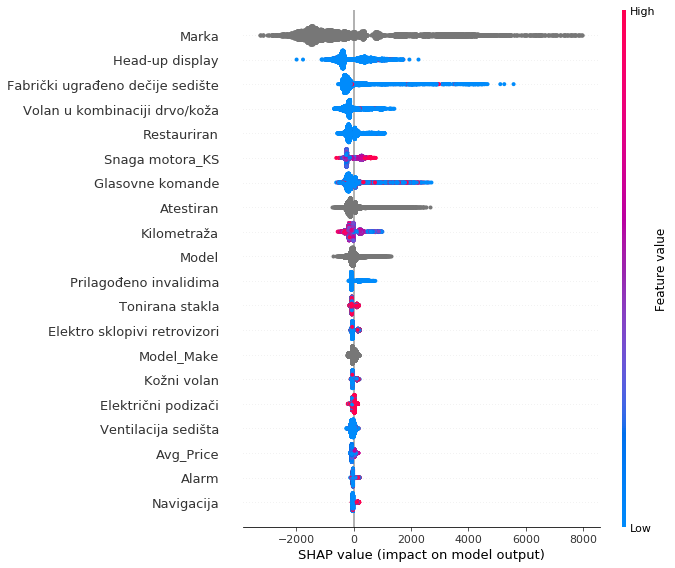

In [0]:
shap.summary_plot(shap_values, X_test)

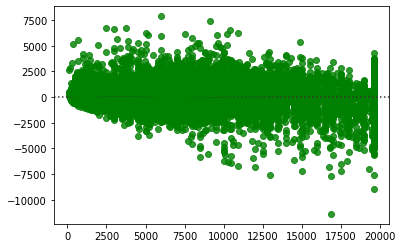

In [0]:
sns.residplot(y_train, model.predict(train_data), lowess=True, color="g")

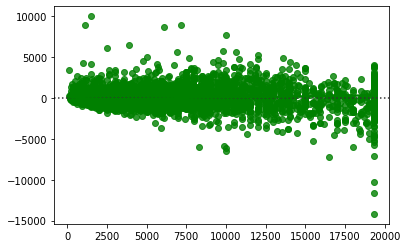

In [0]:
sns.residplot(y_val, model.predict(val_data), lowess=True, color="g")

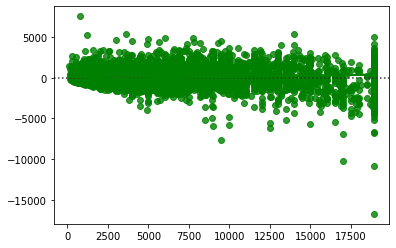

In [0]:
sns.residplot(y_test, model.predict(test_data), lowess=True, color="g")

In [0]:
X_train.head(1).to_csv(d+'Models/df_example.csv')

In [0]:
summary.to_csv(d+'Models/avg_price.csv')

In [0]:
model.predict(val_data)

array([3694.48912808, 2159.02155545, 2425.50512757, ..., 7731.30527976,
       3727.78915738, 7467.9250655 ])

In [0]:
# for c in df.select_dtypes(include='object').columns.tolist():
#     df[c] = df[c].astype('category')
# X = df.values
# X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=100)

# train_data = lightgbm.Dataset(X_train, y_train, categorical_feature=df.select_dtypes(include='category').columns.tolist())
# test_data = lightgbm.Dataset(X_test, y_test, reference=train_data)
# parameters = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# model = lightgbm.train(parameters,
#                 train_data,
#                 num_boost_round=20,
#                 valid_sets=test_data,
#                 early_stopping_rounds=5)